In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
condition = "eAUC22C"
all_gwas_path =  "/cluster/scratch/afeurtey/Kmer_GWAS/5_GWAS_results/"
dir_path = all_gwas_path + "GWAS_output_dir_" + condition + "/kmers/"

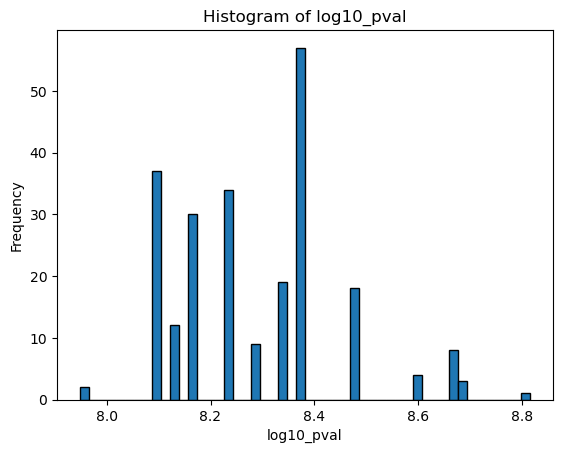

In [8]:


df = pd.read_csv(dir_path + 'pass_threshold_10per', sep='\t')

# Add a new column with -log10 of values from column 'p_lrt'
df['log10_pval'] = -np.log10(df['p_lrt'])

df
# Save the updated dataframe to a new CSV file
#df.to_csv('updated_pass_threshold_10per.csv', index=False)

# Plot histogram from the new column
plt.hist(df['log10_pval'], bins=50, edgecolor='black')
plt.title('Histogram of log10_pval')
plt.xlabel('log10_pval')
plt.ylabel('Frequency')
plt.show()

In [9]:

#Read only 10000 first lines of tsv file
df = pd.read_csv(dir_path + 'output/phenotype_value.assoc.txt.gz', sep='\t')

# Add a new column with -log10 of values from column 'p_lrt'
df['log10_pval'] = -np.log10(df['p_lrt'])

df



,chr,rs,ps,n_miss,allele1,allele0,af,l_mle,p_lrt,log10_pval
0,0,AAAAAAGCTCAGCCTTCTTCTTGCTGCTTCG_4728,0,0,0,1,0.929,0.000010,0.000044,4.359084
1,0,AAAAAAGGGCGGTAAACTGCACAATTAGAGT_6447,0,0,0,1,0.941,0.000010,0.000005,5.344795
2,0,AAAAAAGTAACACCTTAAAAAAGCAGCTCTC_1850,0,0,0,1,0.053,0.406219,0.000020,4.697540
3,0,AAAAAAGTCCACCGCGAAACTCTCCCCATCT_7649,0,0,0,1,0.941,0.000010,0.000059,4.231369
4,0,AAAAACACCAAATAAATCCACAAATACATGG_7859,0,0,0,1,0.935,0.000010,0.000068,4.167512
...,...,...,...,...,...,...,...,...,...,...
9996,0,TTGCTTCTCGTCCACTCGCGTTCACGACAAA_5176,0,0,0,1,0.938,0.632176,0.000064,4.193273
9997,0,TTGGATGGTTGTGCAGGATGGCCCACTGAAA_6328,0,0,0,1,0.570,0.566879,0.000072,4.141781
9998,0,TTGGTATGAGATTTAATGCCTGAGGCACAAA_9815,0,0,0,1,0.932,0.691861,0.000122,3.914691
9999,0,TTGGTTTCGTGAGGAAGTCCCGGACAAAAAA_4724,0,0,0,1,0.598,0.000010,0.000051,4.289707


In [10]:
single_value_df = pd.read_csv(dir_path + 'threshold_10per', nrows=1, header=None, sep='\t')
single_value = single_value_df.iloc[0, 0]
print(single_value)

7.93679


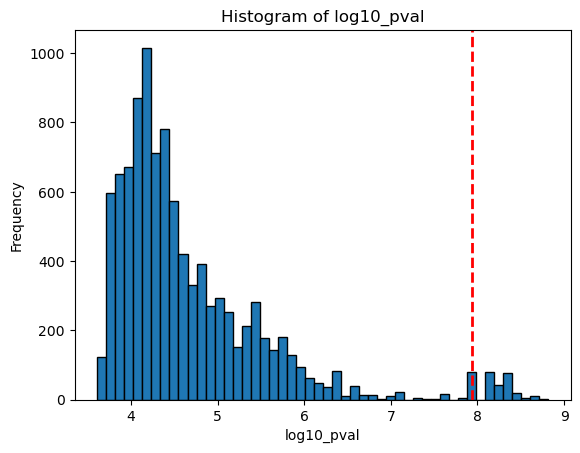

In [11]:


# Plot histogram
plt.hist(df['log10_pval'], bins=50, edgecolor='black')

# Add vertical line
plt.axvline(single_value, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram of log10_pval')
plt.xlabel('log10_pval')
plt.ylabel('Frequency')
plt.show()

In [12]:
columns_names = ["rs", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue bitscore", "lala"]
pos_df = pd.read_csv(dir_path + 'output/phenotype_value.assoc_for_fetch.blast.tsv', sep='\t', 
                     header=None,  index_col = None, names = columns_names)

pos_df = pos_df[["rs", "sseqid", "sstart", "send"]]
pos_df["position"] = (pos_df["sstart"] + pos_df["send"]) / 2
pos_df["position"] = pos_df["position"].astype(int)
pos_df  = pos_df[["rs", "sseqid", "position"]]
pos_df


,rs,sseqid,position
0,AAAAAAGTAACACCTTAAAAAAGCAGCTCTC_1850,8,1024218
1,AAAAAGAGAAGGAATTGAACCCGCGACATTT_9697,20,297936
2,AAAAAGAGAAGGAATTGAACCCGCGACATTT_9697,3,388298
3,AAAAAGAGAAGGAATTGAACCCGCGACATTT_9697,6,1614738
4,AAAAAGAGAAGGAATTGAACCCGCGACATTT_9697,1,4972750
...,...,...,...
6745,TTGAACCCGCGACATTTAAAGCTAGATTCAA_344,20,297950
6746,TTGAACCCGCGACATTTAAAGCTAGATTCAA_344,3,388312
6747,TTGGTATGAGATTTAATGCCTGAGGCACAAA_9815,15,427806
6748,TTGGTTTCGTGAGGAAGTCCCGGACAAAAAA_4724,16,469494


In [13]:
df2 = pd.merge(pos_df, df, on='rs', how='inner')
df2

df2 = df2[df2['sseqid'] != 'mt']
print(df2.shape)
# Create a new column that is the rank of the order of the chromosomes
df2['chromosome'] = df2['sseqid'].astype('category')
df2['chromosome'] = df2['chromosome'].astype(int).astype('category')

df2['chr_index'] = df2['chromosome'].cat.codes

# Calculate cumulative position along the genome
# Sort the DataFrame by chromosome and position
df2 = df2.sort_values(['chromosome', 'position'])

# Calculate the difference between the current and previous position
df2['position_diff'] = df2.groupby('chromosome')['position'].diff()

# Replace NaN values with the original position
df2['position_diff'] = df2['position_diff'].fillna(df2['position'])

df2['cumulative_position'] = df2['position_diff'].transform(lambda x: x.cumsum())
df2['global_position'] = df2['cumulative_position'] + df2['chr_index'] * 1e7  # add gaps between chromosomes


df2

print(f" -- Found {df['rs'].nunique()} significant kmers.")
print(f" -- Found {df2['rs'].nunique()} significant kmers aligning on the genome.")

(6749, 12)


/tmp/ipykernel_11583/1041159725.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2['position_diff'] = df2.groupby('chromosome')['position'].diff()


,rs,sseqid,position,chr,ps,n_miss,allele1,allele0,af,l_mle,p_lrt,log10_pval,chromosome,chr_index,position_diff,cumulative_position,global_position
4459,CGCCTAATGCCGGGATAGGCGGATTTCTATC_7570,1,10650,0,0,0,0,1,0.718,0.260665,8.807177e-05,4.055163,1,0,10650.0,10650.0,10650.0
4460,CGCCTAATGCCGGGATAGGCGGATTTCTATC_7570,1,19420,0,0,0,0,1,0.718,0.260665,8.807177e-05,4.055163,1,0,8770.0,19420.0,19420.0
28,AAACAAAACCGACCTCTCCTTTAGCGGACTG_6109,1,22141,0,0,0,0,1,0.913,0.290701,1.390206e-04,3.856921,1,0,2721.0,22141.0,22141.0
2550,ATACCTTAGAGCTCTGCCTCGTCTAGTTCTG_9303,1,41244,0,0,0,0,1,0.854,0.279532,1.430810e-04,3.844418,1,0,19103.0,41244.0,41244.0
730,AATCTACTATTGTTCAGAGCGTACTAAATAT_2903,1,42032,0,0,0,0,1,0.687,0.000010,2.178891e-05,4.661764,1,0,788.0,42032.0,42032.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,ACTGTAGCTGGTAACAGAACTAGATGCTATG_1078,21,408420,0,0,0,0,1,0.907,0.000010,4.082492e-06,5.389075,21,20,1.0,39364722.0,239364722.0
5080,CTGTAGCTGGTAACAGAACTAGATGCTATGC_1077,21,408420,0,0,0,0,1,0.907,0.000010,4.082492e-06,5.389075,21,20,0.0,39364722.0,239364722.0
2196,AGGTAGGTATAAAGATTTCGTTAATAAAATG_2097,21,408664,0,0,0,0,1,0.755,0.000010,8.322909e-06,5.079725,21,20,244.0,39364966.0,239364966.0
561,AAGGTAGGTATAAAGATTTCGTTAATAAAAT_743,21,408665,0,0,0,0,1,0.737,0.000010,1.206697e-06,5.918402,21,20,1.0,39364967.0,239364967.0


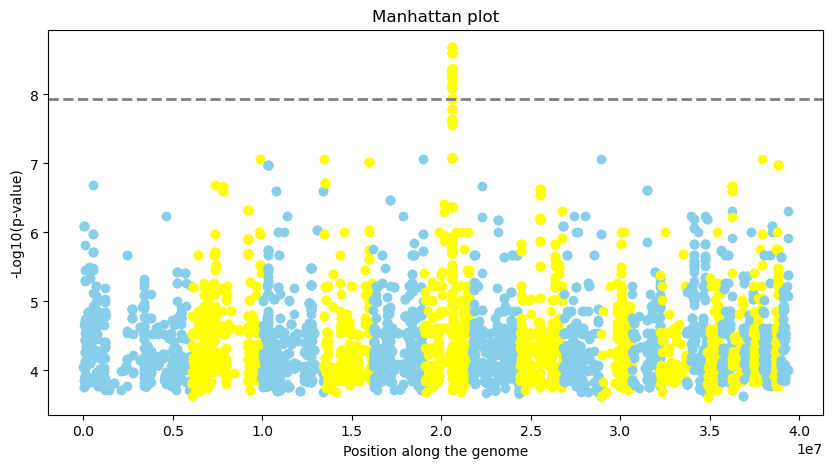

<Figure size 640x480 with 0 Axes>

In [14]:


# Create the Manhattan plot
plt.figure(figsize=(10, 5))
#plt.scatter(df2['cumulative_position'], df2['log10_pval'], color='skyblue')
# Define colors
colors = ['skyblue', 'yellow']
for chrom, data in df2.groupby('chr_index'):
    plt.scatter(data['cumulative_position'], data['log10_pval'], color=colors[chrom % len(colors)])
plt.axhline(single_value, color='grey', linestyle='dashed', linewidth=2)
plt.ylabel('-Log10(p-value)')
plt.xlabel('Position along the genome')
plt.title('Manhattan plot')
plt.show()

# Save plot to file
plt.savefig(all_gwas_path + 'manhattan_plot_' + condition + '.png')

In [15]:
#Filter the dataframe to keep only the significant values
df2 = df2[df2['log10_pval'] > single_value]
df2

#Write file to disk
df2.to_csv(all_gwas_path + 'significant_kmers_blast_IPO323' + condition + '.tsv', sep='\t', index=False)

print(f"Significant kmers saved to {all_gwas_path + 'significant_kmers_blast_IPO323' + condition + '.tsv'}")



,rs,sseqid,position,chr,ps,n_miss,allele1,allele0,af,l_mle,p_lrt,log10_pval,chromosome,chr_index,position_diff,cumulative_position,global_position
5498,GATACCACGCTCGTCACACATCTCCTCCTCA_120,6,1565367,0,0,0,0,1,0.839,0.00001,5.720071e-09,8.242599,6,5,2.0,20607091.0,70607091.0
419,AAGATACCACGCTCGTCACACATCTCCTCCT_119,6,1565368,0,0,0,0,1,0.839,0.00001,5.720071e-09,8.242599,6,5,1.0,20607092.0,70607092.0
1752,AGATACCACGCTCGTCACACATCTCCTCCTC_103,6,1565368,0,0,0,0,1,0.839,0.00001,5.720071e-09,8.242599,6,5,0.0,20607092.0,70607092.0
3581,CATACCACGCTCGTCACACATCTCCTCCTCA_13,6,1565368,0,0,0,0,1,0.167,0.00001,2.471607e-09,8.607021,6,5,0.0,20607092.0,70607092.0
937,ACATACCACGCTCGTCACACATCTCCTCCTC_12,6,1565369,0,0,0,0,1,0.167,0.00001,2.471607e-09,8.607021,6,5,1.0,20607093.0,70607093.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,CCCTGCATGTGATTCCGCGTCCCATTTGCGG_335,6,1565659,0,0,0,0,1,0.198,0.00001,5.088707e-09,8.293393,6,5,1.0,20607383.0,70607383.0
4202,CCTGCATGTGATTCCGCGTCCCATTTGCGGA_338,6,1565660,0,0,0,0,1,0.198,0.00001,5.088707e-09,8.293393,6,5,1.0,20607384.0,70607384.0
4946,CTCCGCAAATGGGACGCGGAATCACATGCAG_333,6,1565661,0,0,0,0,1,0.198,0.00001,5.088707e-09,8.293393,6,5,1.0,20607385.0,70607385.0
6652,TCTCCGCAAATGGGACGCGGAATCACATGCA_332,6,1565662,0,0,0,0,1,0.198,0.00001,5.088707e-09,8.293393,6,5,1.0,20607386.0,70607386.0
